# Fraud Detection Model

In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
from sklearn.model_selection import StratifiedKFold, cross_val_score
import shap
import joblib


### Exploratory Data Analysis

In [2]:
# Load Dataset
df = pd.read_csv('PS_20174392719_1491204439457_log.csv')

# Preview
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [3]:
# Basic Info
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [4]:
# Checking Balance
df['isFraud'].value_counts(normalize=True)

isFraud
0    0.998709
1    0.001291
Name: proportion, dtype: float64

In [5]:
# Counting Balance
df['isFraud'].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

In [6]:
# Check for missing values
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

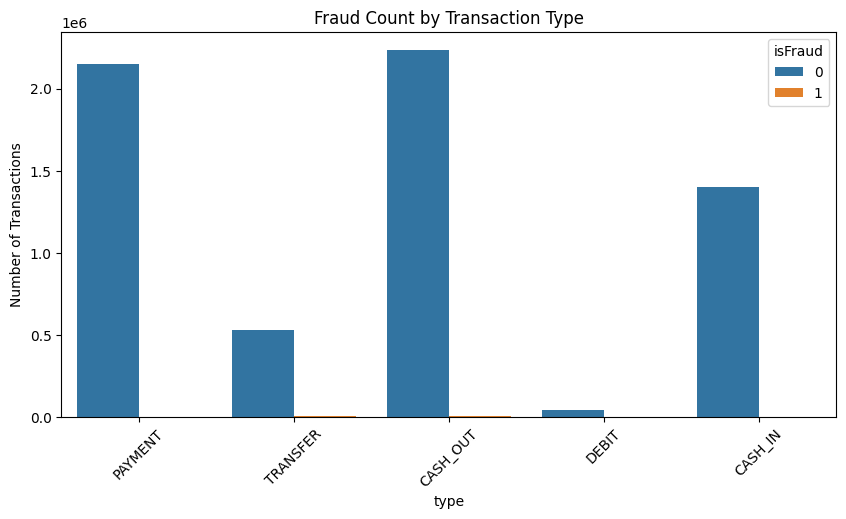

In [7]:
# Visualize Fraud by Transaction Type
plt.figure(figsize=(10,5))
sns.countplot(data = df, x = 'type', hue = 'isFraud' )
plt.title("Fraud Count by Transaction Type")
plt.ylabel("Number of Transactions")
plt.xticks(rotation=45)
plt.show()


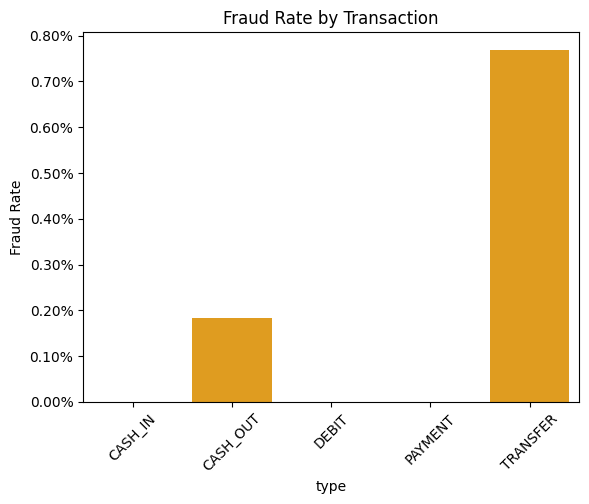

In [8]:
# Visualize Fraud Rate by Transaction Type
fraud_rate = df.groupby('type')['isFraud'].mean().reset_index()

sns.barplot(data = fraud_rate, x = 'type', y = 'isFraud', color = 'orange')
plt.title('Fraud Rate by Transaction')
plt.ylabel("Fraud Rate")
plt.xticks(rotation = 45)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

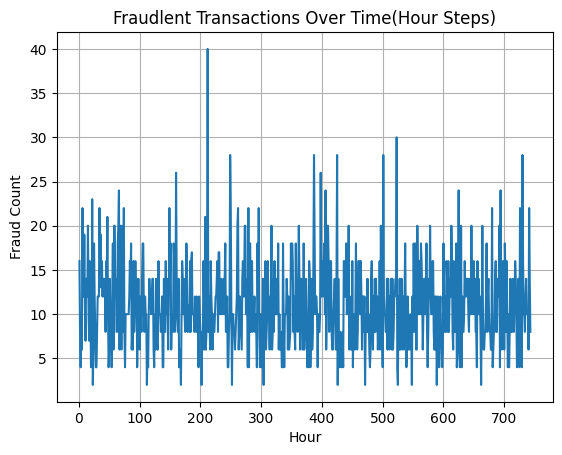

In [9]:
# Visualize Fraud Trends Over Time
fraud_by_time = df[df['isFraud'] == 1]['step'].value_counts().sort_index()
plt.plot(fraud_by_time)
plt.title("Fraudlent Transactions Over Time(Hour Steps)")
plt.xlabel("Hour")
plt.ylabel("Fraud Count")
plt.grid(True)
plt.show()

In [10]:
# Create Day Column
df['day'] = df['step'] // 24

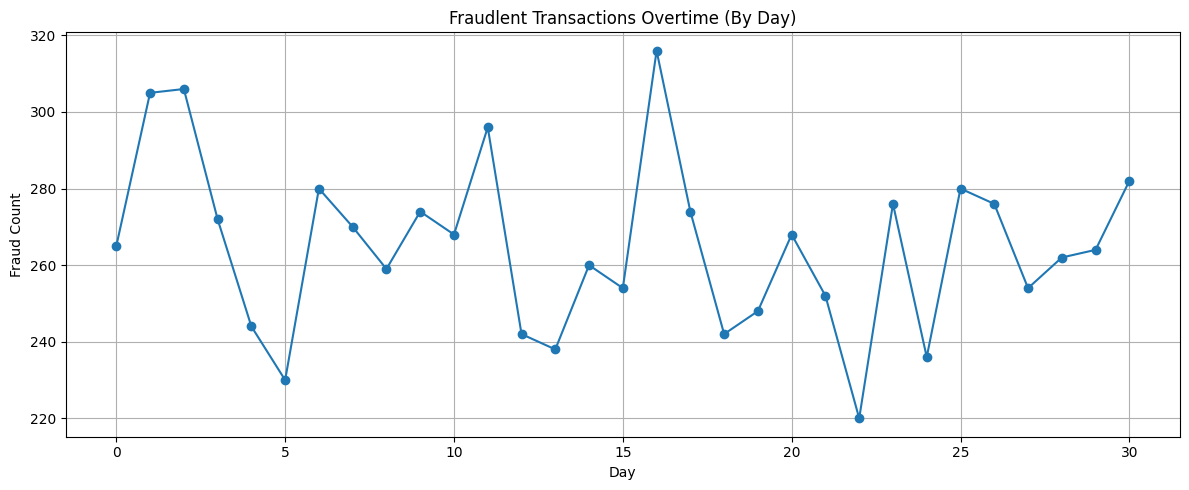

In [11]:
# Visualize New Trends Over Time
fraud_by_day = df[df['isFraud'] == 1]['day'].value_counts().sort_index()

plt.figure(figsize=(12,5))
plt.plot(fraud_by_day, marker = 'o')
plt.title("Fraudlent Transactions Overtime (By Day)")
plt.xlabel("Day")
plt.ylabel('Fraud Count')
plt.grid(True)
plt.tight_layout()
plt.show()


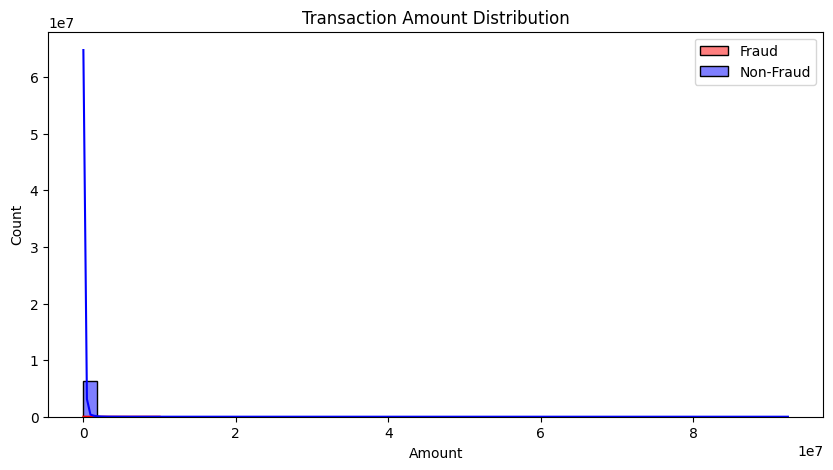

In [12]:
# Visualize Transaction Amounts by Fraud Staus
plt.figure(figsize=(10,5))
sns.histplot(df[df['isFraud'] == 1]['amount'], bins = 50, color = 'red', label = 'Fraud', kde = True)
sns.histplot(df[df['isFraud'] == 0]['amount'], bins = 50, color = 'blue', label = 'Non-Fraud', kde = True)
plt.legend()
plt.title('Transaction Amount Distribution')
plt.xlabel('Amount')
plt.show()

In [13]:
# Compare median transaction amounts
median_fraud = df[df['isFraud'] == 1]['amount'].median().round()
median_non_fraud = df[df['isFraud'] == 0]['amount'].median().round()

print(f'The median fraud is: {median_fraud:,.2f}')
print(f'The median non_fraud is: {median_non_fraud:,.2f}')

The median fraud is: 441,423.00
The median non_fraud is: 74,685.00


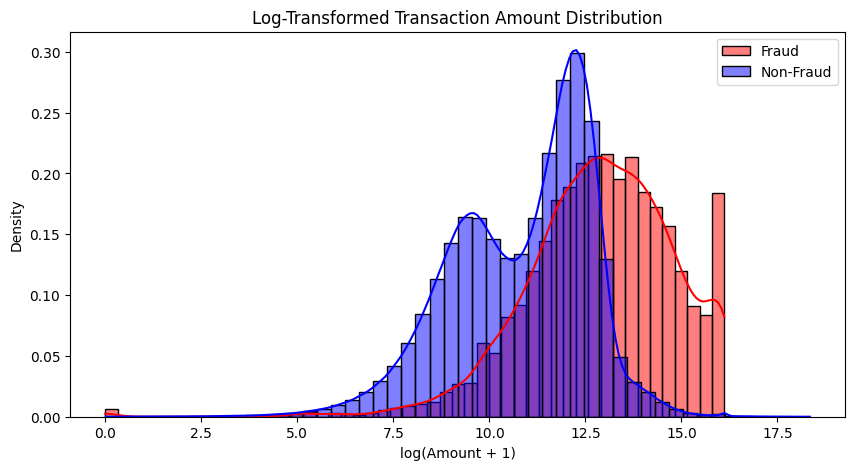

In [14]:
df['log_amount'] = np.log1p(df['amount'])

plt.figure(figsize=(10, 5))
sns.histplot(df[df['isFraud'] == 1]['log_amount'], bins=50, color='red', label='Fraud', kde=True, stat='density')
sns.histplot(df[df['isFraud'] == 0]['log_amount'], bins=50, color='blue', label='Non-Fraud', kde=True, stat='density')
plt.legend()
plt.title("Log-Transformed Transaction Amount Distribution")
plt.xlabel("log(Amount + 1)")
plt.ylabel("Density")
plt.show()

In [15]:
# Suspicious Destination Acounts
top_fraud_test = df[df['isFraud'] == 1]['nameDest'].value_counts().head(10)
print(top_fraud_test)

nameDest
C967226405     2
C1601170327    2
C650699445     2
C105660024     2
C1981613973    2
C803116137     2
C505532836     2
C964377943     2
C200064275     2
C1259079602    2
Name: count, dtype: int64


In [16]:
unique_fraud_dest = df[df['isFraud'] == 1]['nameDest'].nunique()
print(f"Unique destination accounts involved in fraud: {unique_fraud_dest}")

Unique destination accounts involved in fraud: 8169


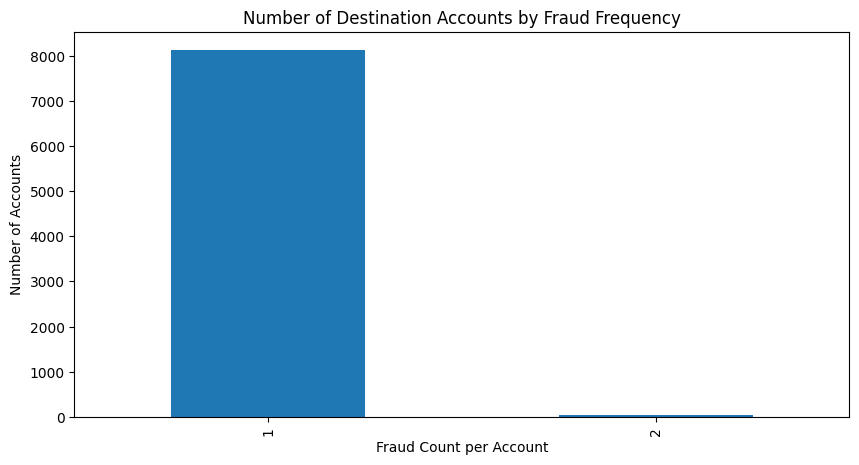

In [17]:
fraud_dest_counts = df[df['isFraud'] == 1]['nameDest'].value_counts()
fraud_dest_counts.value_counts().sort_index().plot(kind='bar', figsize = (10,5))
plt.title("Number of Destination Accounts by Fraud Frequency")
plt.xlabel("Fraud Count per Account")
plt.ylabel("Number of Accounts")
plt.show()


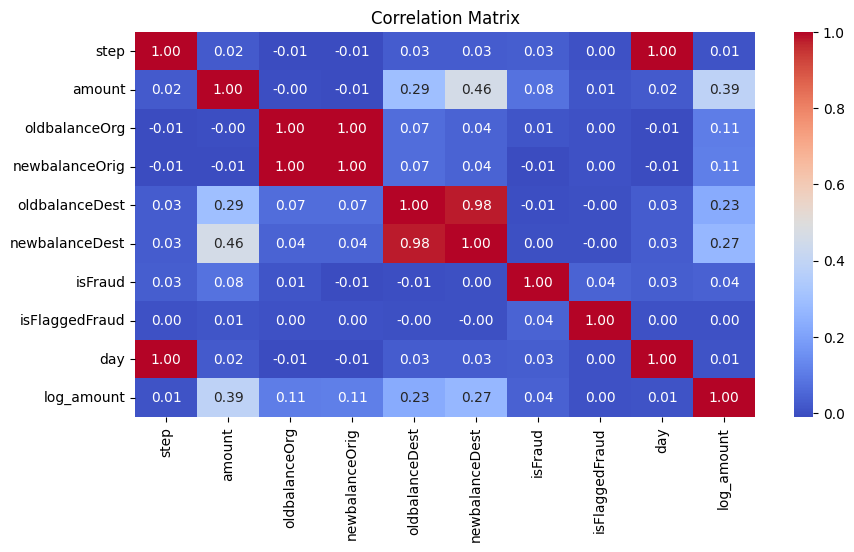

In [18]:
# Correlation Matrix
corr = df.corr(numeric_only=True)
plt.figure(figsize=(10,5))
sns.heatmap(corr, annot=True, fmt = '.2f', cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

# Data PreProcessing & Feature Engineering

In [19]:
# Feature Engineering

# Origin account drained or not
df['balance_delta_orig'] = df['oldbalanceOrg'] - df['amount']

# Destination balance change (suspicious if no change)
df['balance_delta_dest'] = df['newbalanceDest'] - df['oldbalanceDest']

# Ratio of amount to available balance
df['amount_to_balance_ratio'] = df['amount'] / (df['oldbalanceOrg']+1)

In [20]:
# Drop redudant and not helpful columns

df.drop(['newbalanceOrig', 'newbalanceDest', 'isFlaggedFraud', 'step', 'nameOrig', 'nameDest'], axis=1, inplace=True)

In [21]:
# Encode Catergorial Variables

df['type'] = df['type'].astype('category').cat.codes

# Modeling

In [26]:
# Split Data into Train/Test Sets

x = df.drop('isFraud', axis = 1)
y = df['isFraud']

In [27]:
# Stratified Split

X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=.2, stratify=y, random_state=23)

In [ ]:
# Random Forest Model

rf_model = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=23,
    n_jobs=1
)

# Train the model

rf_model.fit(X_train, Y_train)

RandomForestClassifier(class_weight='balanced', n_jobs=1, random_state=23)

In [29]:
# Predictions

y_pred = rf_model.predict(X_test)
y_probs = rf_model.predict_proba(X_test)[:,1]

In [35]:
# Metrics

print("Confusion Matrix: \n", confusion_matrix(Y_test, y_pred))
print("\nClassification Report: \n", classification_report(Y_test, y_pred))
print(f"AUC Score: {roc_auc_score(Y_test, y_probs): .4f}")

Confusion Matrix: 
 [[1270881       0]
 [      4    1639]]

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       1.00      1.00      1.00      1643

    accuracy                           1.00   1272524
   macro avg       1.00      1.00      1.00   1272524
weighted avg       1.00      1.00      1.00   1272524

AUC Score:  0.9988


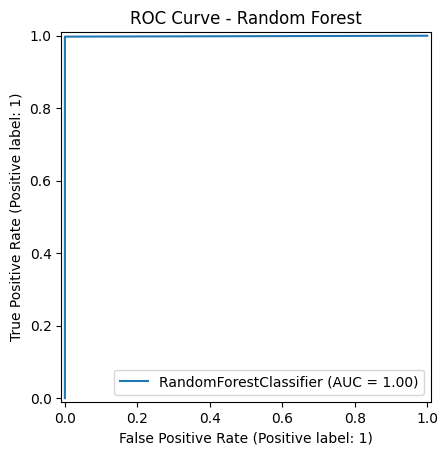

In [36]:
# ROC Curve

RocCurveDisplay.from_estimator(rf_model, X_test, Y_test)
plt.title("ROC Curve - Random Forest")
plt.show()

In [41]:
# Reinitialize the model for Cross Validation

rf_cv_model = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=23,
    n_jobs=-1
)

In [42]:
# Set up Stratified K Fold to maintain fraud ratio

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=23)

In [43]:
# 5 Fold Cross Validation

cv_scores = cross_val_score(rf_cv_model, x, y, cv=skf, scoring='roc_auc', n_jobs=-1)

In [44]:
# New Metrics

print(f"Cross-Validated AUC Scores: {cv_scores}")
print(f"Mean AUC Score: {cv_scores.mean(): .4f}")
print(f"Standard Deviation: {cv_scores.std(): .4f}")

Cross-Validated AUC Scores: [0.99604078 0.99878168 0.99817364 0.99908684 0.99847807]
Mean AUC Score:  0.9981
Standard Deviation:  0.0011


# Feature Importance

In [45]:
# Get Feature Importances

importances = rf_model.feature_importances_

In [46]:
# DataFrame

feature_names = X_train.columns
feat_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

In [47]:
# Sort by Importance

feat_importances = feat_importances.sort_values(by='Importance', ascending=False)

# Display top Features

print(feat_importances)

                   Feature  Importance
6       balance_delta_orig    0.391649
8  amount_to_balance_ratio    0.328182
0                     type    0.068469
2            oldbalanceOrg    0.067026
5               log_amount    0.053637
1                   amount    0.041152
7       balance_delta_dest    0.034734
4                      day    0.009878
3           oldbalanceDest    0.005273


C:\Users\danie\AppData\Local\Temp\ipykernel_40376\4281076941.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_importances, x = 'Importance', y = "Feature", palette= 'viridis')


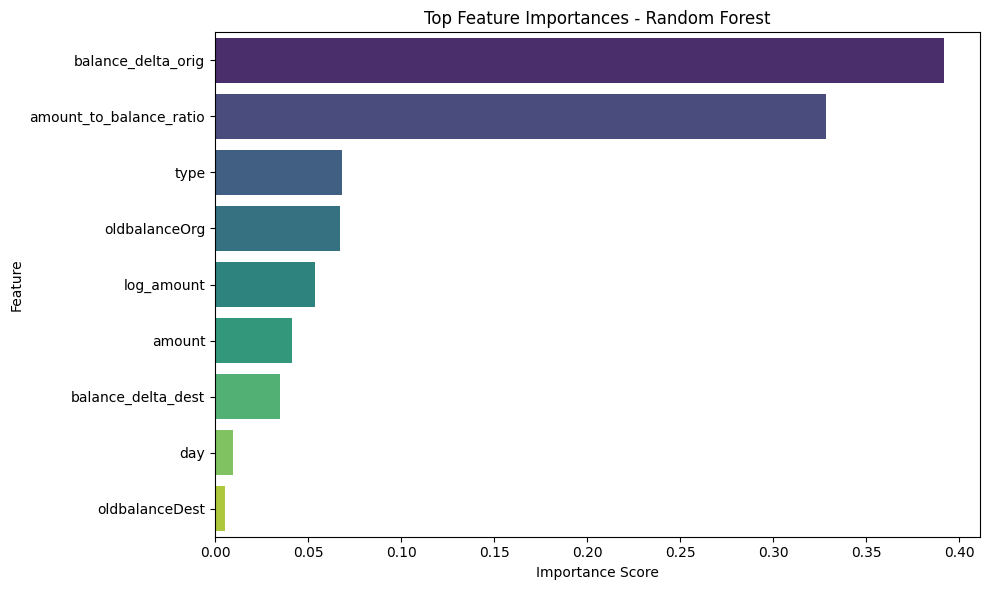

In [50]:
# Plot Top Features

plt.figure(figsize=(10,6))
sns.barplot(data=feat_importances, x = 'Importance', y = "Feature", palette= 'viridis')
plt.title("Top Feature Importances - Random Forest")
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Saving Model

In [64]:
# Save Trained Model

joblib.dump(rf_model, 'fraud_rf_model.pk1')

['fraud_rf_model.pk1']

In [65]:
# Load Model Back

loaded_model = joblib.load('fraud_rf_model.pk1')

In [66]:
loaded_preds = loaded_model.predict(X_test)